In [2]:
import torch
import torch.nn as nn

device = torch.device('cuda')

In [3]:
from tqdm import tqdm

In [4]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [5]:
from random import randint

In [6]:
import matplotlib.pyplot as plt

In [7]:
t = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset_train = FashionMNIST(root="../datasets/", train=True, download=False)
dataset_test = FashionMNIST(root="../datasets/", train=False, download=False)

In [8]:
import torch.nn.functional as F

In [9]:
X_train = dataset_train.data.type(torch.float)
Y_train = dataset_train.targets

X_test = dataset_test.data.type(torch.float)
Y_test = dataset_test.targets

X_train = F.interpolate(X_train.unsqueeze(dim=1), size=(224,224))
X_test = F.interpolate(X_test.unsqueeze(dim=1), size=(224,224))

X_train.shape
X_test.shape

torch.Size([10000, 1, 224, 224])

In [29]:
dataset_train.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

torch.Size([1, 224, 224])
tensor(9)


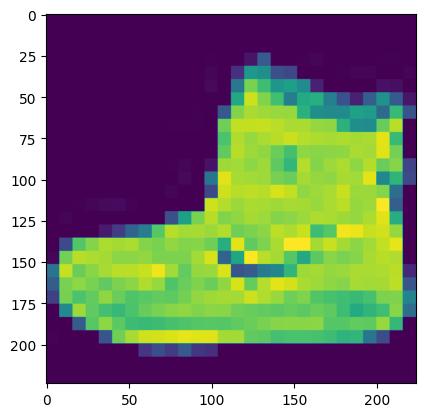

In [10]:
sx, sy = X_train[0], Y_train[0]
print(sx.shape)
print(sy)
plt.imshow(sx.squeeze())

In [36]:
class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(11, 11), stride=(4, 4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5,5), padding=(2,2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(3,3),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=24, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)), 
            nn.Flatten(),
            nn.Linear(in_features=24*5*5, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [39]:
x = torch.concat([torch.randn(224,224)]).reshape(1, 1, 224, 224)
x.shape
model = alexnet()
model(x).shape

torch.Size([1, 10])

In [40]:
model = alexnet()
model = model.to(device)
def acc_fn(pred, target):
    return (pred.argmax(dim=1)==target).sum()

In [42]:
BS = 128

N_EPOCHS = 5

B_EPOCHS = int(60_000 / BS)

optim = torch.optim.SGD(params=model.parameters(), lr=0.001)

loss_fn = nn.NLLLoss()

losses = []
accs = []

for _ in tqdm(range(N_EPOCHS)):
    for b in range(B_EPOCHS):
        optim.zero_grad()
        i = randint(0, 60_000-BS)
        pred = model(X_train[i:i+BS].to(device))
        targets = Y_train[i:i+BS].to(device)
        acc = acc_fn(pred, targets).item()/BS
        loss = loss_fn(pred, targets)
        losses.append(loss.item()/BS)
        loss.backward()
        optim.step()
        if b % 300 == 0: 
            print("batch:", b, "acc:", acc, "loss:", loss.item()/BS)

  0%|                                                                                                                 | 0/5 [00:00<?, ?it/s]

batch: 0 acc: 0.75 loss: 0.004393843002617359
batch: 300 acc: 0.84375 loss: 0.004090883769094944


 20%|█████████████████████                                                                                    | 1/5 [00:03<00:13,  3.45s/it]

batch: 0 acc: 0.8359375 loss: 0.003418412758037448
batch: 300 acc: 0.8125 loss: 0.003717155195772648


 40%|██████████████████████████████████████████                                                               | 2/5 [00:06<00:10,  3.44s/it]

batch: 0 acc: 0.8125 loss: 0.003841344965621829
batch: 300 acc: 0.8671875 loss: 0.003991474863141775


 60%|███████████████████████████████████████████████████████████████                                          | 3/5 [00:10<00:06,  3.44s/it]

batch: 0 acc: 0.890625 loss: 0.0034268423914909363
batch: 300 acc: 0.8984375 loss: 0.0027723610401153564


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 4/5 [00:13<00:03,  3.44s/it]

batch: 0 acc: 0.8203125 loss: 0.003975589759647846
batch: 300 acc: 0.8515625 loss: 0.003383191069588065


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.44s/it]


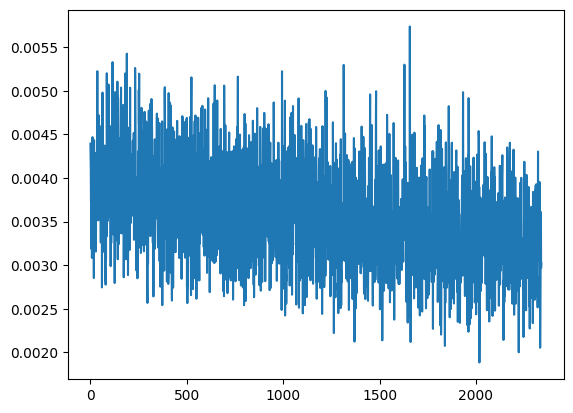

In [43]:
plt.plot(losses)